# Medical Image Classification

In this little project I am going to use an exercise I had during my studies at KIT as a domain to explore different methods of Transfer Learning and model architectures using PyTorch.

## Data Loading & Analysis

In [168]:
import os
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms
import torch
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


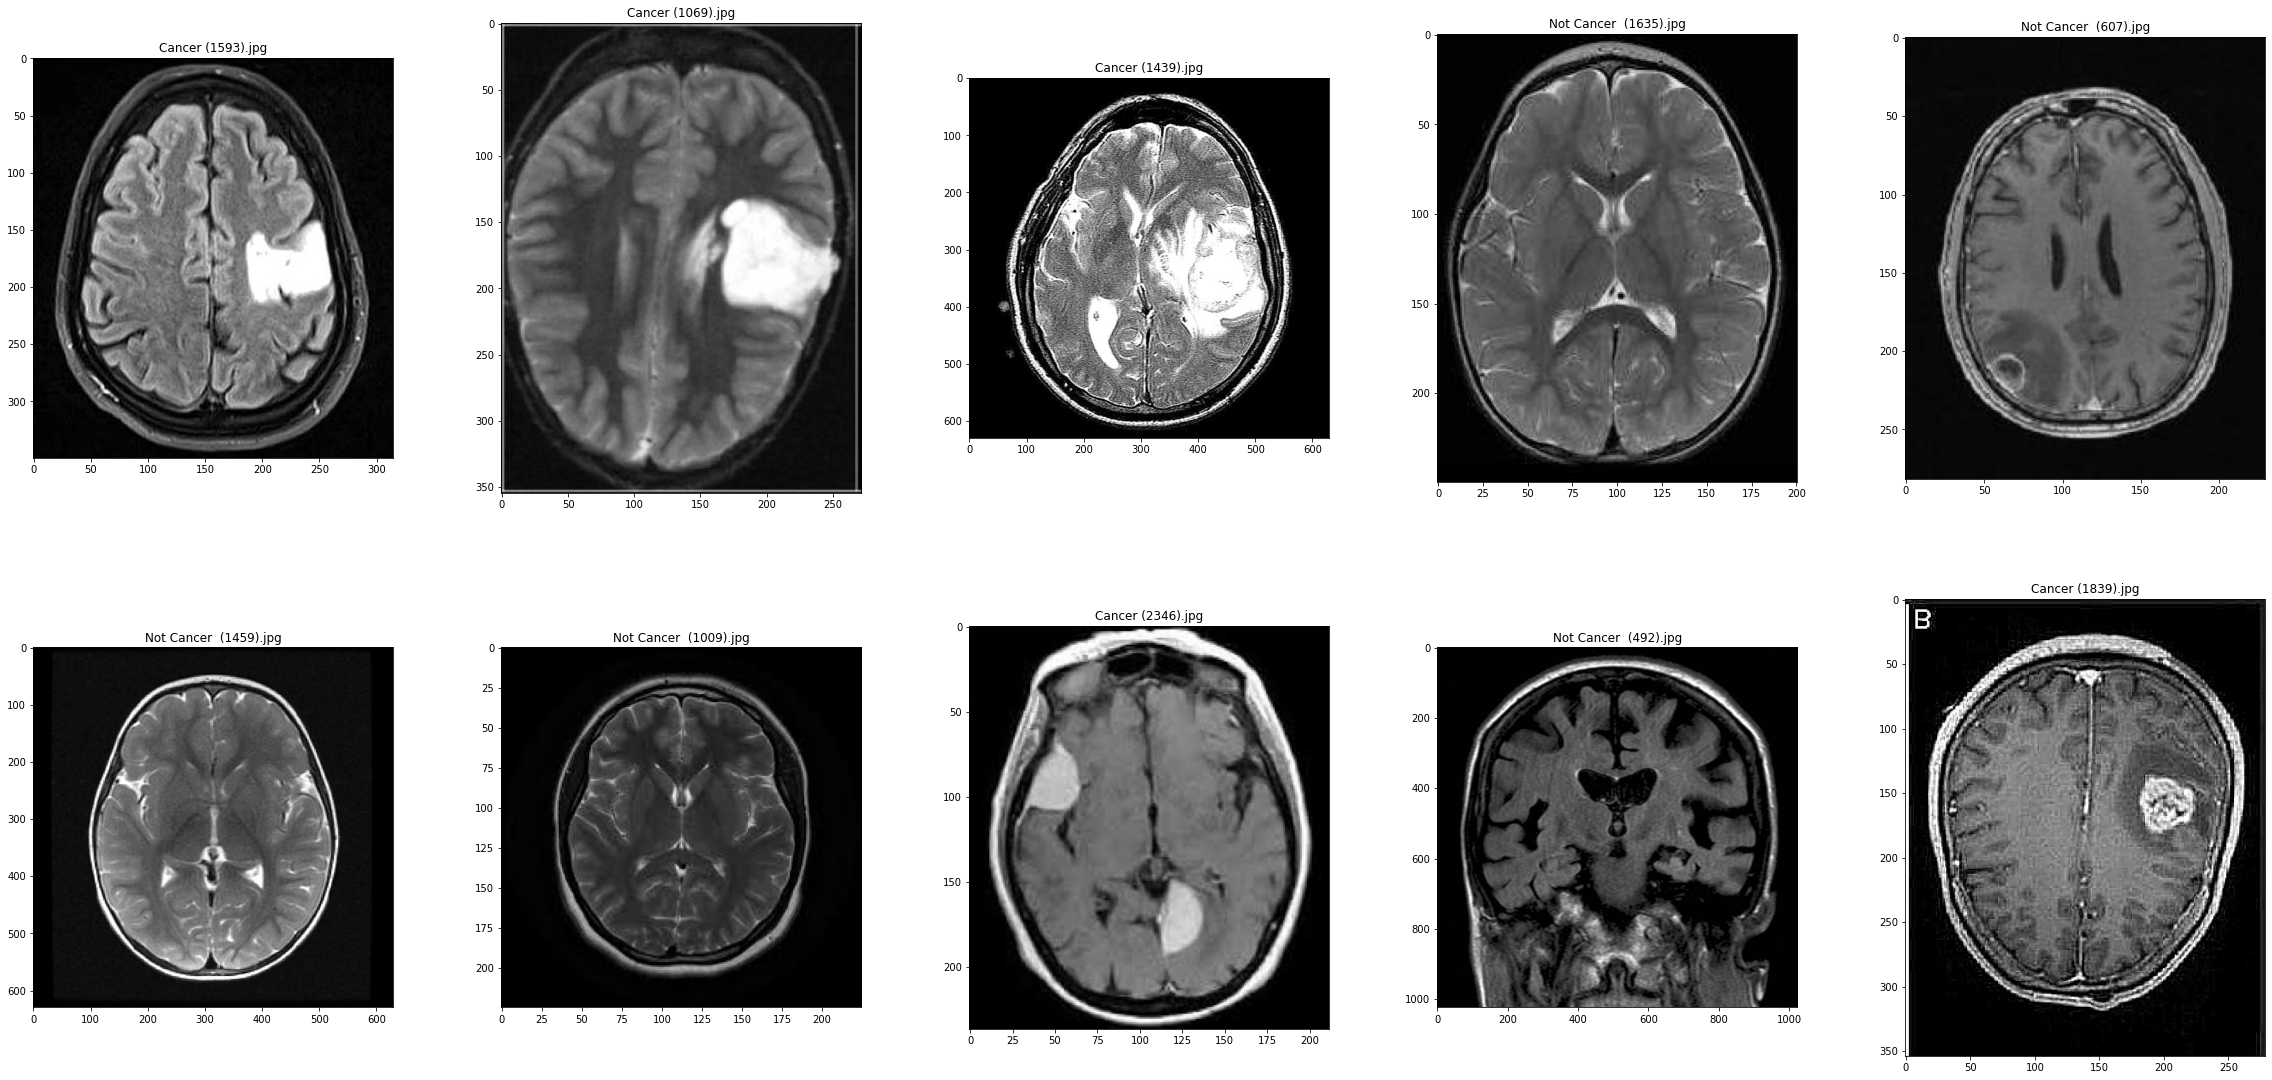

In [121]:
img_dir = './dataset' # path of image directory
images = os.listdir(img_dir)

# plot 10 x-ray images
fig, axes = plt.subplots(2, 5, figsize=(40,20), gridspec_kw=dict(hspace=0.1, wspace=0.3))
for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(os.path.join(img_dir, images[i])))
    ax.set_title(images[i])

In [122]:
# implement tumor_df as pd.DataFrame for train/test split and further data process
img_names = [] # [] # list contains image name
img_labels = [] # list contains labels (0 as not cancer, 1 as cancer)
tumor_df = None
for i in images:
    img_names.append(i)
    img_labels.append(0 if 'Not Cancer' in i else 1)

# YOUR CODE HERE
tumor_df = pd.DataFrame()
tumor_df["name"] = pd.Series(img_names)
tumor_df["label"] = pd.Series(img_labels)

In [123]:
class TumorImageDataset(Dataset):
    """load, transform and return image and label"""
    def __init__(self, annotations_df, img_dir, transform=None):
        self.img_labels= annotations_df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        # get image path according to idx
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # convert all image to RGB format
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        # apply image transform
        if self.transform:
            image = self.transform(image)
        return [image, label]

In [177]:
annotations = pd.read_csv('data/Data_Entry_2017_v2020.csv')
annotations.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                        0.143  0.143  
2                        0.168  0.168  
3                        0.171  0.171  
4                        0.168  0.168

In [178]:
labels = set()
for l in annotations['Finding Labels'].unique():
    labels.update(l.split("|"))
labels = list(labels)
    
# now create seperate columns for each of these labels
annot_df = pd.concat([annotations, pd.DataFrame(columns=labels)])

# set 1 where the Finding contains the corresponding label, otherwise 0
for label in labels:
    annot_df.loc[annot_df['Finding Labels'].str.contains(label), label] = 1
    pass
annot_df.loc[:, labels] = annot_df.loc[:, labels].fillna(0)

annot_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly          0.0         1.0   
1  00000001_001.png  Cardiomegaly|Emphysema          1.0         1.0   
2  00000001_002.png   Cardiomegaly|Effusion          2.0         1.0   
3  00000002_000.png              No Finding          0.0         2.0   
4  00000003_001.png                  Hernia          0.0         3.0   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0         57.0              M            PA               2682.0   2749.0   
1         58.0              M            PA               2894.0   2729.0   
2         58.0              M            PA               2500.0   2048.0   
3         80.0              M            PA               2500.0   2048.0   
4         74.0              F            PA               2500.0   2048.0   

   OriginalImagePixelSpacing[x  ...  Hernia  Atelectasis  Cardiomegaly  \
0                        0.143  ...       0            0             1   
1                        0.143  ...       0            0             1   
2                        0.168  ...       0            0             1   
3                        0.171  ...       0            0             0   
4                        0.168  ...       1            0             0   

   Effusion  Consolidation  Fibrosis  Mass  Infiltration  Nodule  Pneumonia  
0         0              0         0     0             0       0          0  
1         0              0         0     0             0       0          0  
2         1              0         0     0             0       0          0  
3         0              0         0     0             0       0          0  
4         0              0         0     0             0       0          0  

[5 rows x 26 columns]

In [179]:
# remove rows for all images that are NOT in our dataset right now
from os import listdir
from os.path import isfile, join
image_data_path = './data/images/'
image_filenames_list = [f for f in listdir(image_data_path) if isfile(join(image_data_path, f))]

In [180]:
annot_df = annot_df[annot_df['Image Index'].isin(image_filenames_list)]
annot_df.shape # we get around 5000 images right now

(4929, 26)

In [181]:
class MedicalImageDataset(Dataset):
    """
    This implements PyTorch's dataset class to allow for easy access to the data through DataLoaders.
    """
    
    def __init__(self, images_path, data_df, label_cols, transformation=None):
        self.images_path = images_path
        self.df = data_df
        self.y = data_df.loc[:, label_cols]
        self.transformation = transformation
        
    def __len__(self):
        return self.df.shape[0]
        
    def __getitem__(self, index):
        # create full image path
        image_data = self.df.iloc[index]
        image_path = os.path.join(self.images_path, image_data['Image Index'])
        
        # open image and apply transformation
        image_file = Image.open(image_path)# .convert("RGB")
        image_file.draft('L', (1024,1024))
        
        if self.transformation:
            try:
                image_file = self.transformation(image_file)
            except:
                print(f"Error at {image_path}")
        else:
            image_file = torch.tensor(
                np.array(image_file.getdata()).reshape(image_file.size[0], image_file.size[1], )
            )
        
        # return image data as well as labels_vector
        return (image_file, torch.tensor(self.y.iloc[index].values))

In [182]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    lambda img: img.view(1024, 1024, 1).repeat((1,1,3)).permute((2,0,1))
])

In [183]:
# Split the dataset
train, test = train_test_split(annot_df, random_state=42)

# Create dataloaders
train_data = DataLoader(MedicalImageDataset('./data/images/', train, labels, transformation=transformation), batch_size=32, shuffle=False)
test_data = DataLoader(MedicalImageDataset('./data/images/', test, labels, transformation=transformation), batch_size=32, shuffle=False)

# create dict for later use
datasets = {
    'train': train,
    'test': test
}
dataloaders = {
    'train': train_data, 
    'test': test_data
}

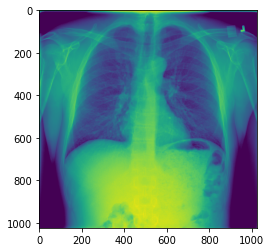

In [158]:
# plot a batch (32) of image in training set
train_features, train_labels = next(iter(train_data)) # DataLoader is iterable
plt.imshow(train_features[0][0,:,:])

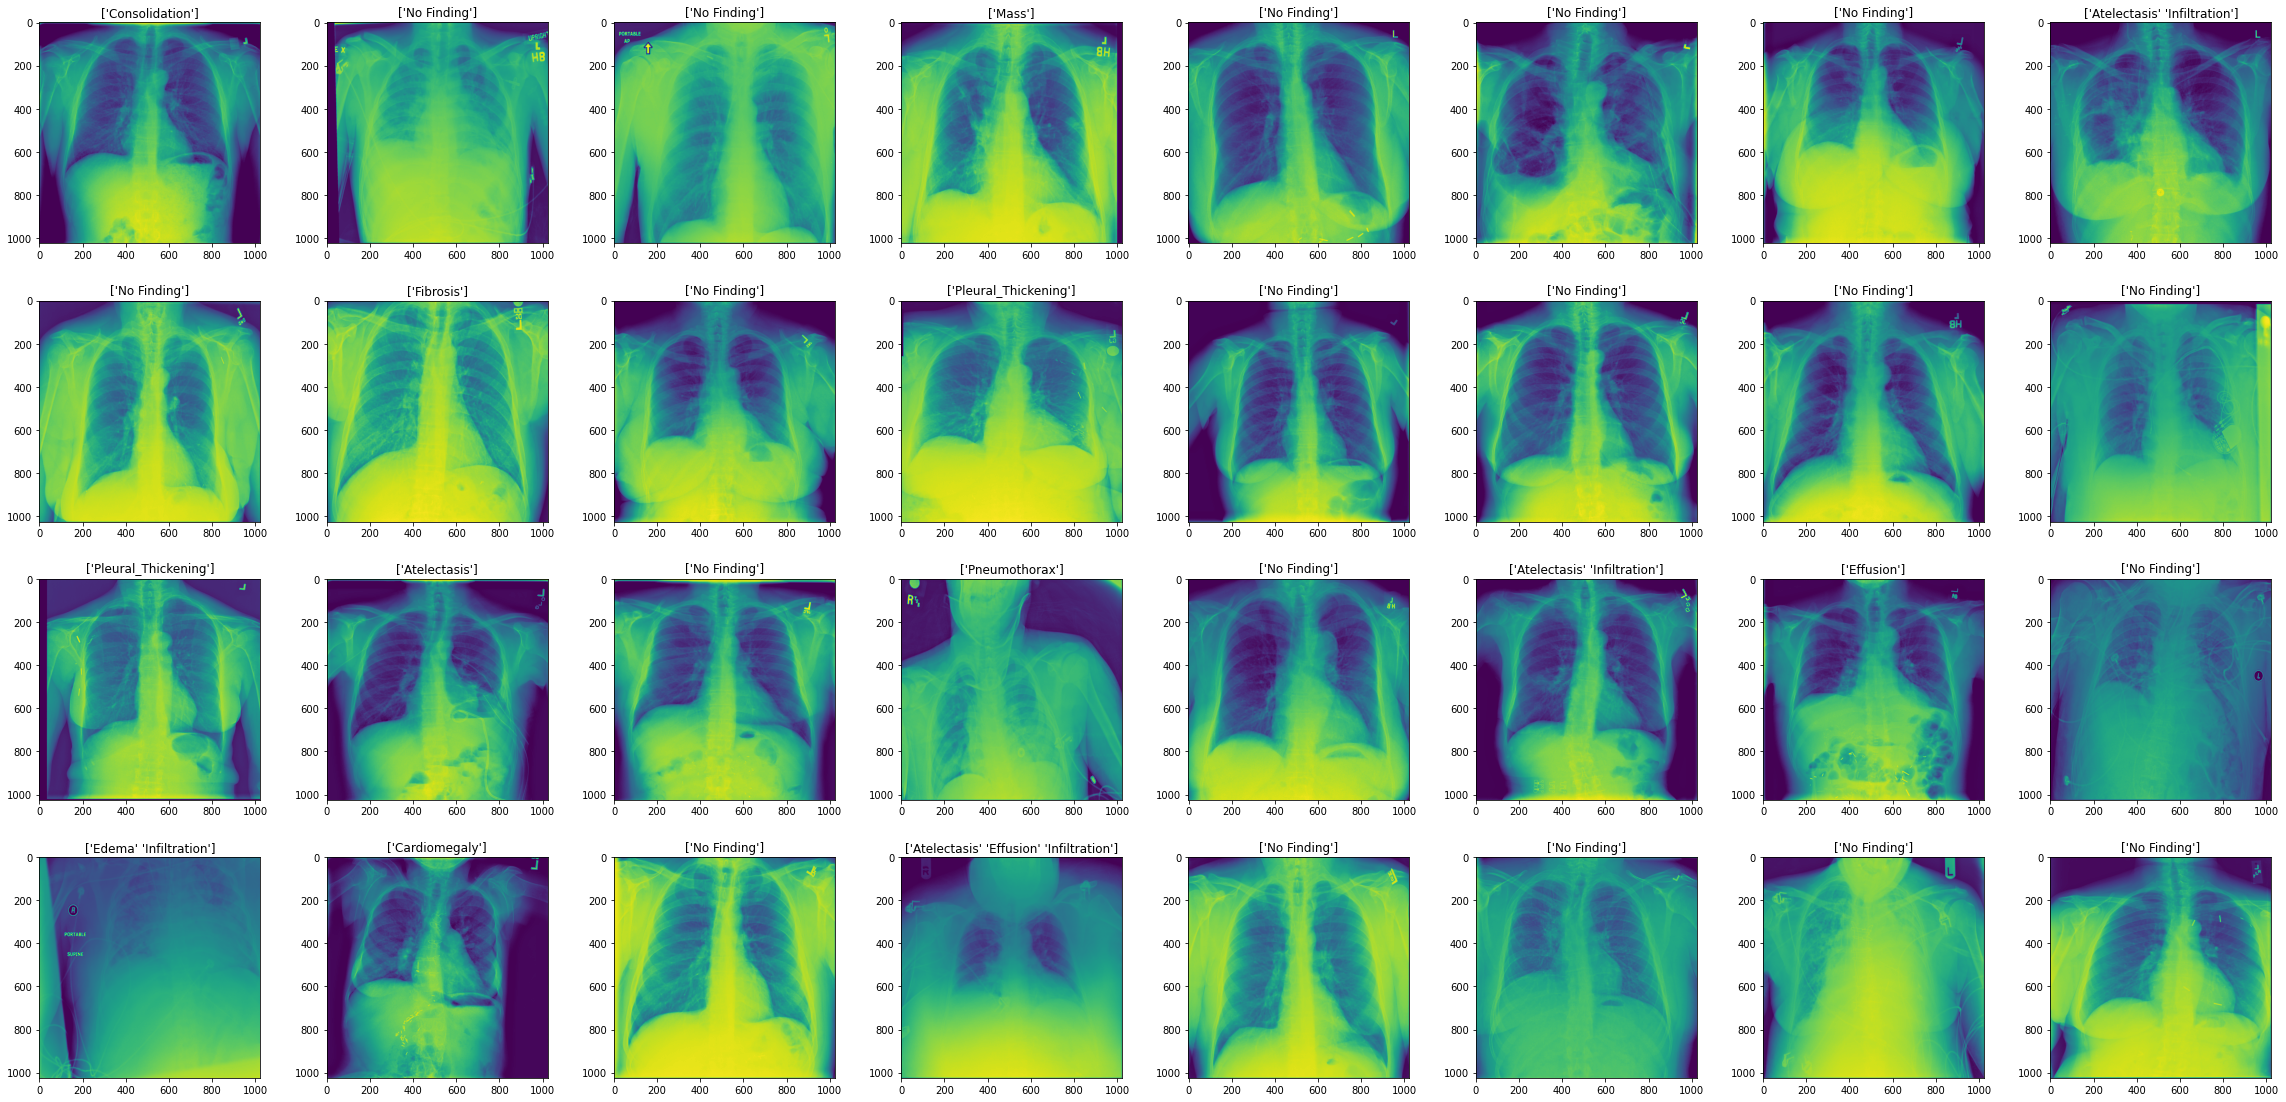

In [63]:
# plot a batch (32) of image in training set
nlabels = np.array(labels)
train_features, train_labels = next(iter(train_data)) # DataLoader is iterable
fig, axes = plt.subplots(4, 8, figsize=(40,20), gridspec_kw=dict(hspace=0.1, wspace=0.3))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_features[i][0,:,:])
    ax.set_title(str(nlabels[(train_labels[i] == 1).numpy().reshape(15,)]))

## Build a Model

In this section we are going to build our model.
Instead of learning a Convolutional Neural Network from scratch, we are going to use a pretrained model and retrain it according to our data using Transfer Learning.

In [29]:
import torchvision
from torchsummary import summary
from torch import nn

In [140]:
# load the model
resnet = torchvision.models.resnet18(pretrained=True)

# freeze the parameters
for param in resnet.parameters():
    param.requires_grad = False
    
# summary(resnet, input_size=(3,512,512))

### Modifying the model

Since we don't want predict 1000 different classes but to predict a few different labels (remember: our task is multi-label classification), we will have to change the last fully-connected layer.

In [141]:
resnet.fc = nn.Sequential(
    nn.Linear(in_features=resnet.fc.in_features, out_features=len(nlabels)),
    nn.Sigmoid() # classic
)

In [142]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's explore this part again:
`in_features` is an argument to describe how many features this layer will take in. Since we did not modify the previous layer and it's output, we are going to use the `in_features` that this layer was taking previously.

Since this will be our last layer, the number of `out_features` is task-specific. In our case, we have `len(nlabels) = 15` different output dimensions, we want to explore.

## Training & Evaluation

In [153]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25):
    import time
    from rich.progress import Progress
    
    with Progress() as progress:
        epochs = progress.add_task("Epochs", total=num_epochs)
        samples = progress.add_task("Samples", total=5000)
        
        # data keeping
        epoch_losses = []

        for epoch in range(num_epochs):
            
            # training loop
            for phase in ['train', 'test']:
                
                # set model state to phase
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                
                # go through batches
                for X, y in dataloaders[phase]:
                    X = X.to(device)
                    y = y.to(device)
                    
                    # clear the buffers
                    optimizer.zero_grad()
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        y_pred = model(X)
                        loss = criterion(y_pred, y.to(torch.float32))

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                            # track loss for training
                            epoch_losses.append(float(loss))
                    
                    # update progress bar      
                    progress.update(samples, advance=32)

In [111]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25):
    from rich.progress import track
    since = time.time()

    # best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.to(torch.float32))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    # return model

In [185]:
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

train_model(resnet, loss, optimizer, dataloaders, num_epochs=1)

Epochs  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--
Samples ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3% -:--:--

KeyboardInterrupt: 